# Análisis de Patrones de Luz en el Hackerspace San Salvador
Este Notebook contiene el análisis de los datos recolectados por los sensores de presencia instalados en el Hackerspace San Salvador.

## Información Técnica
* **Período de Recolección:** 12 de abril al 26 de abril de 2019
* **Variables recolectadas:**
    * Componente rojo de color (ISL29125)
    * Componente verde de color (ISL29125)
    * Componente azul de color (ISL29125)
    * Paquetes HTTP (Puerto 80) que transitan por el router
    * Paquetes SSL (Puerto 443) que transitan por el router
    * Activación de switch de luz
* **Limitantes de los datos recolectados**: Para el período de captura se identificó que el sensor de luz de color contenía datos faltantes. Se sospecha que la biblioteca que maneja el lector de luz está causando respuestas lentas y bloqueos en la lectura.

## Pre-procesamiento de datos
La base de datos almacena la fecha y la hora que se captura el indicador particular. Para generar un histórico minuto a minuto se utiliza un script que busca todos los valores que son capturados en períodos de un minuto.

En el caso del sensor de color la medición se promedia si se han realizado más de dos mediciones dentro de un período de un minuto.

El switch se considera activo si existe una sola medición de activación durante el período. Si no se encuentran registros durante el período se considera que el switch se encuentra apagado.

Los datos de paquetes se guardan tal cual, en caso de encontrarse más de una medición durante el período se suman ambas. Sin embargo, el número de paquetes se determina restando el valor de la medición actual contra la medición anterior. Como los conteos del router se reinician eventualmente, es posible encontrar algunos números negativos o conteos que se salen considerablemente del rango. Estos conteos han sido excluídos del análisis y se han reemplazado con 0.

### Normalización
Los rangos de lo valores son muy variantes entre sí, para poder graficar los parámetros y observar cambios se han escalado los rangos de tal manera que el máximo valor de cada variable se muestra como un 1 y el mínimo valor como 0. El valor se calcula con la fórmula valor/MAX(serie).

In [32]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

In [33]:
datafile = '../logs/log_20190412_20190510.csv'
data = pd.read_csv(datafile, encoding='utf-8')
data.describe()

r             g             b        switch   http_packets  \
count  14086.000000  14086.000000  14086.000000  35619.000000   16848.000000   
mean     452.765867    479.159307    364.054735      0.136500  212856.162749   
std      607.551089    655.938373    502.649373      0.343324  217119.391646   
min        0.000000      0.000000      0.000000      0.000000       8.000000   
25%        1.000000      1.000000      1.000000      0.000000   16274.000000   
50%      266.000000    303.000000    230.000000      0.000000  147796.500000   
75%      541.000000    563.000000    425.000000      0.000000  494102.000000   
max     3379.000000   4190.000000   2958.000000      1.000000  593081.000000   

        ssl_packets     ipv6_http     ipv6_https  
count  1.684800e+04  16848.000000   16848.000000  
mean   1.863623e+06    142.396961   36866.238901  
std    1.946869e+06    607.625626  142561.415100  
min    0.000000e+00      0.000000       0.000000  
25%    0.000000e+00      0.000000       0.000000  
50%    1.632134e+06      0.000000       0.000000  
75%    4.003507e+06      0.000000       0.000000  
max    5.965172e+06   6701.000000  822038.000000

Agregar columnas auto-calculadas para el cambio de actividad en red.

In [34]:
data['packets'] = data['http_packets'].fillna(0)+data['ssl_packets'].fillna(0)+data['ipv6_http'].fillna(0)+data['ipv6_https'].fillna(0)

Calcular columnas estandarizadas

In [35]:
data['norm_r'] = data['r'].fillna(0)/data['r'].max()
data['norm_g'] = data['g'].fillna(0)/data['g'].max()
data['norm_b'] = data['b'].fillna(0)/data['b'].max()

In [36]:
snapshots = pd.to_datetime(data['start'], format='%Y-%m-%d %H:%M:%S')

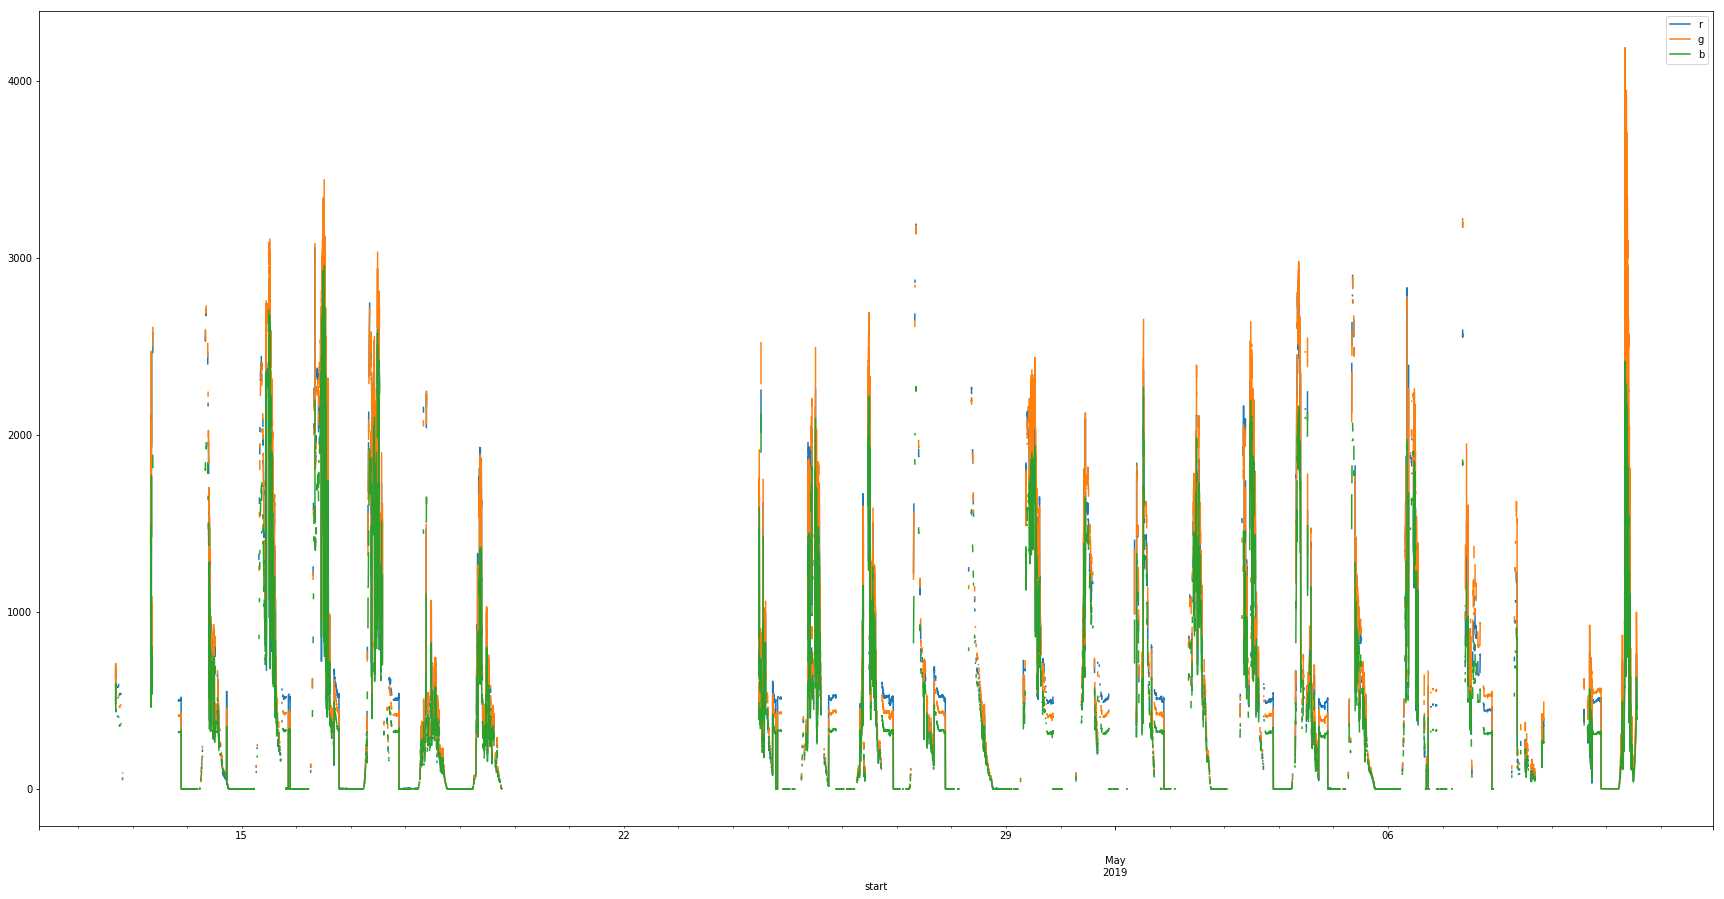

In [37]:
raw_rgb = data.filter(['r','g','b']).join(snapshots)
raw_rgb.plot.line(y=['r','g','b'],x='start',figsize=(30, 15)).get_figure().savefig('./img/raw_rgb_plot.png')

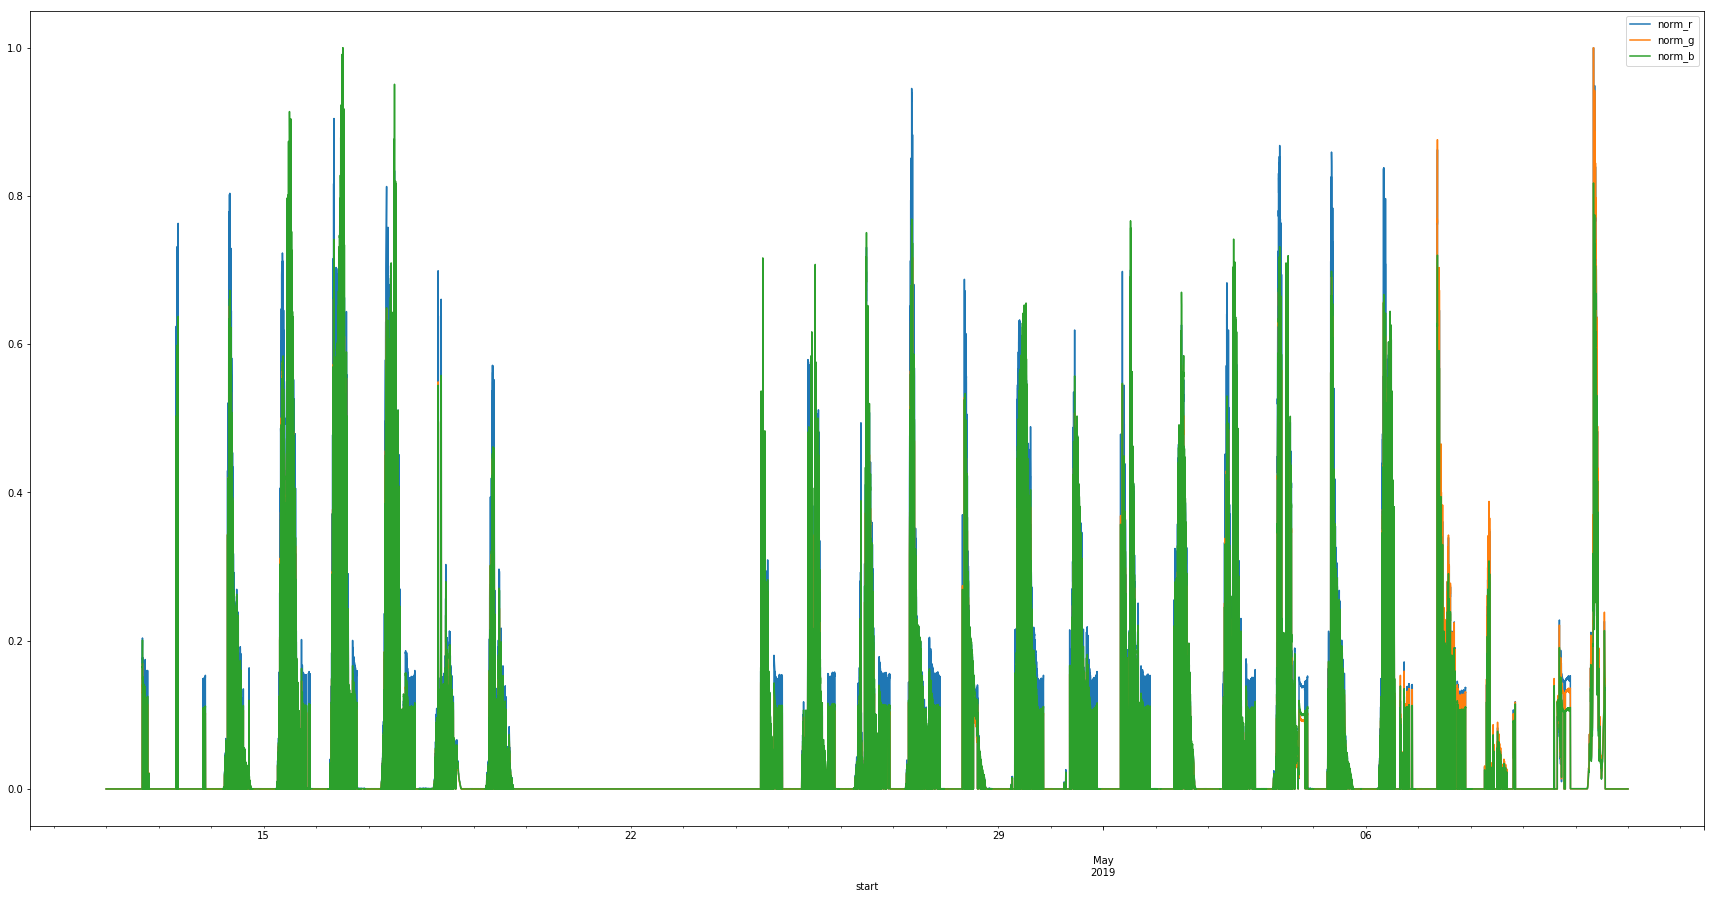

In [38]:
norm_rgb = data.filter(['norm_r','norm_g','norm_b']).join(snapshots)
norm_rgb.plot.line(y=['norm_r','norm_g','norm_b'],x='start',figsize=(30, 15)).get_figure().savefig('./img/norm_rgb_plot.png')

Sobreponemos el valor del switch. No es necesario estandarizar los valores ya que se encuentran entre cero y uno.

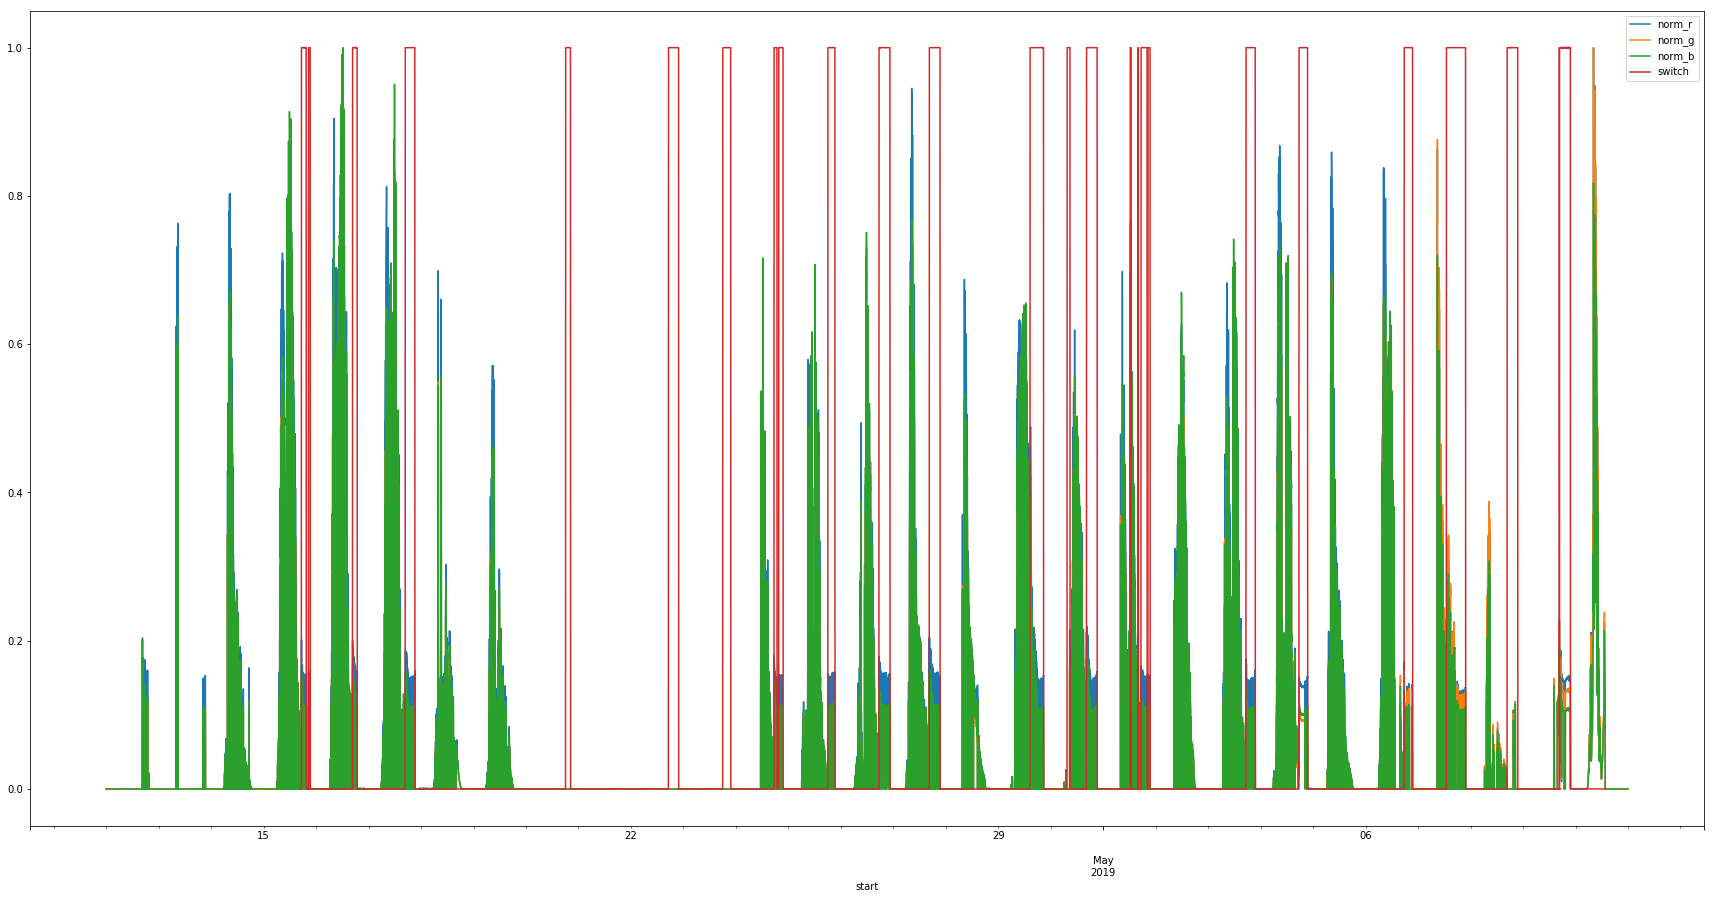

In [39]:
norm_rgb_switch = data.filter(['norm_r','norm_g','norm_b','switch']).join(snapshots)
norm_rgb_switch.plot.line(y=['norm_r','norm_g','norm_b','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/norm_rgb_switch_plot.png')

Calculamos la diferencia de paquetes. Esto se realiza en dos pasos. Como los contadores se reinician a veces se encuentran anomalias que tienen que ser eliminadas. También se estandarizan los valores según actividad.

In [52]:
data['diff_packets'] = data['packets'].diff().fillna(0)
data['diff_packets_nonzero'] = data['diff_packets'].clip(0,10000)
data['diff_packets_nonzero_norm'] = data['diff_packets_nonzero']/10000

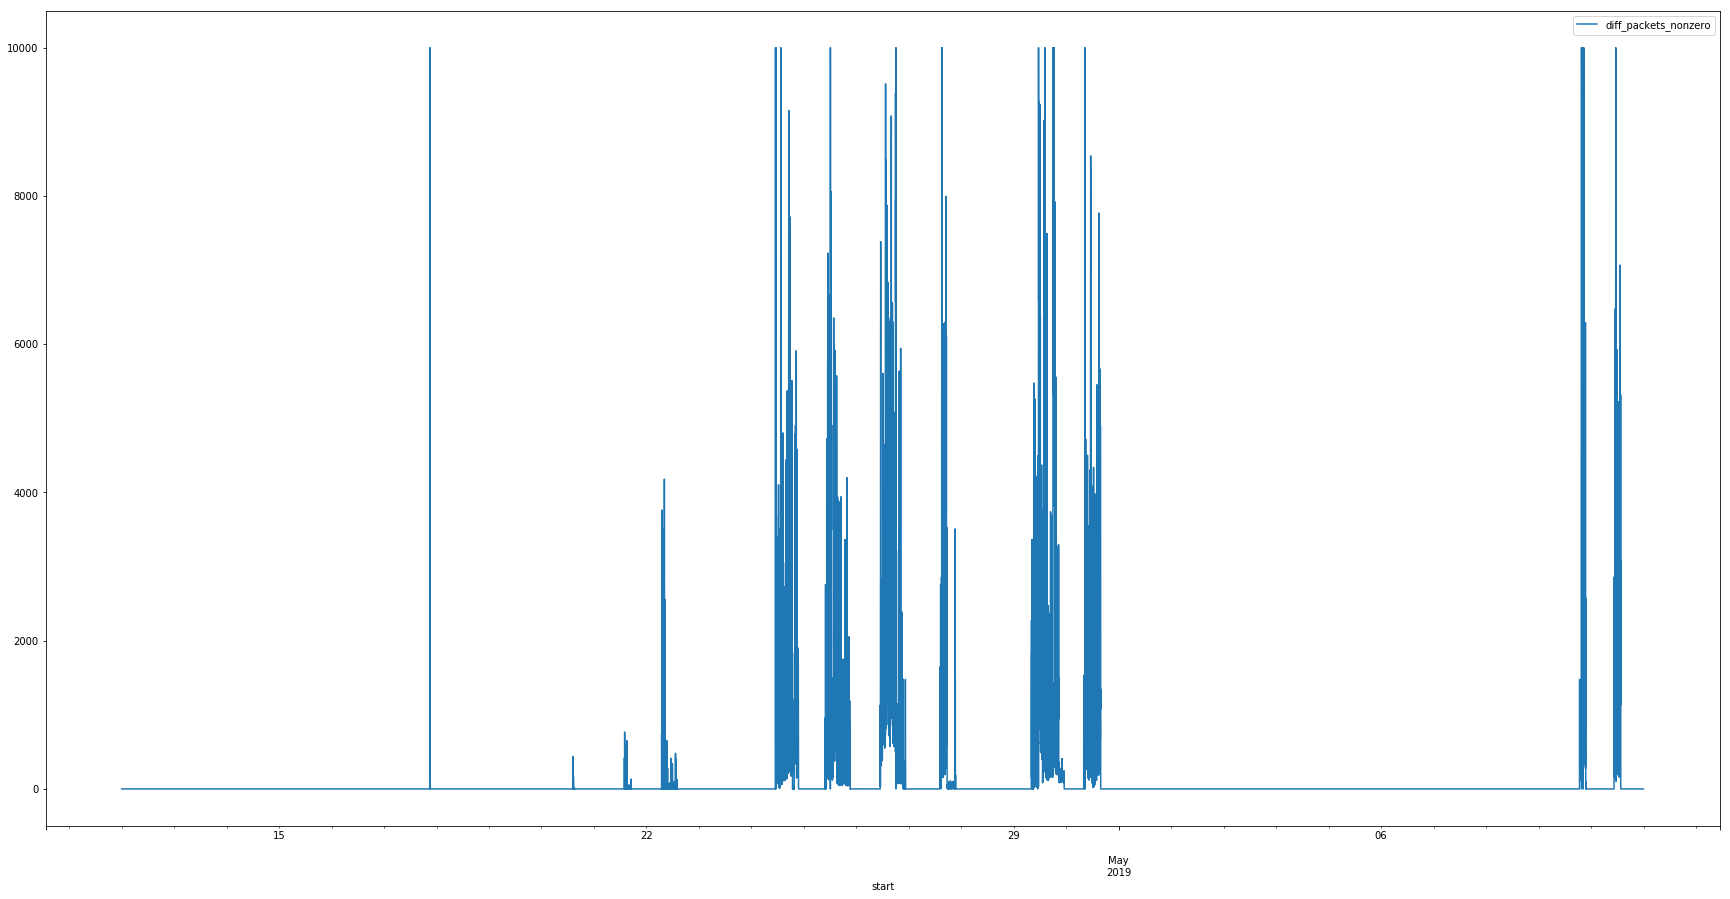

In [53]:
network = data.filter(['diff_packets_nonzero']).join(snapshots)
network.plot.line(y=['diff_packets_nonzero'],x='start',figsize=(30, 15)).get_figure().savefig('./img/network_plot.png')

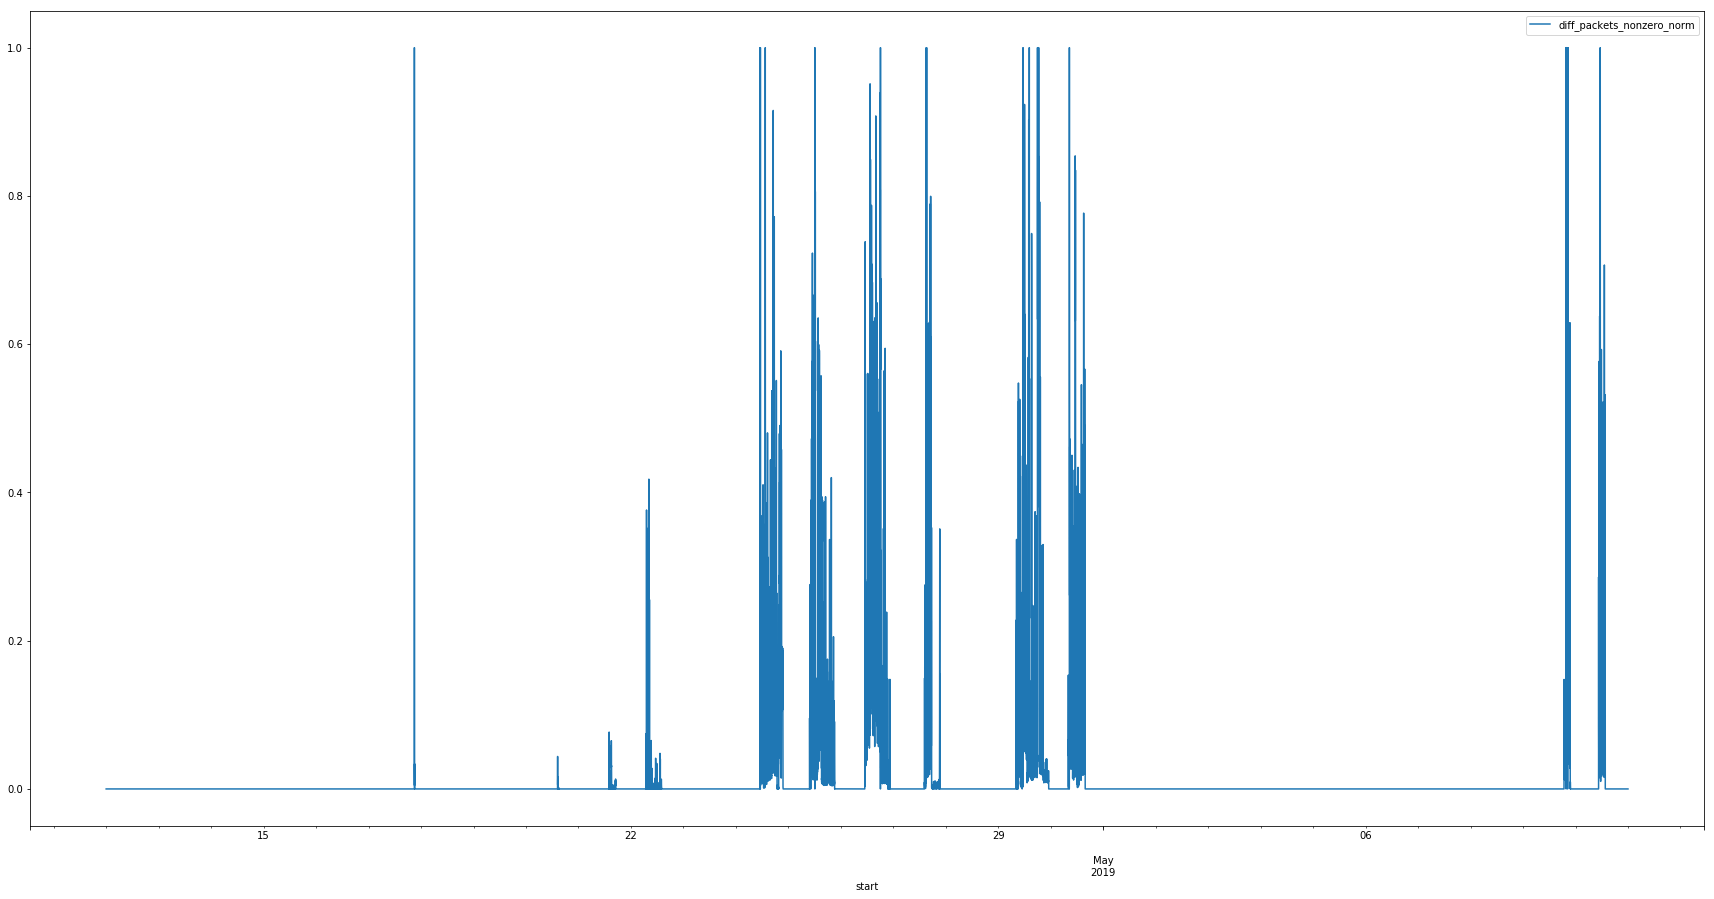

In [54]:
network_norm = data.filter(['diff_packets_nonzero_norm']).join(snapshots)
network_norm.plot.line(y=['diff_packets_nonzero_norm'],x='start',figsize=(30, 15)).get_figure().savefig('./img/network_norm_plot.png')

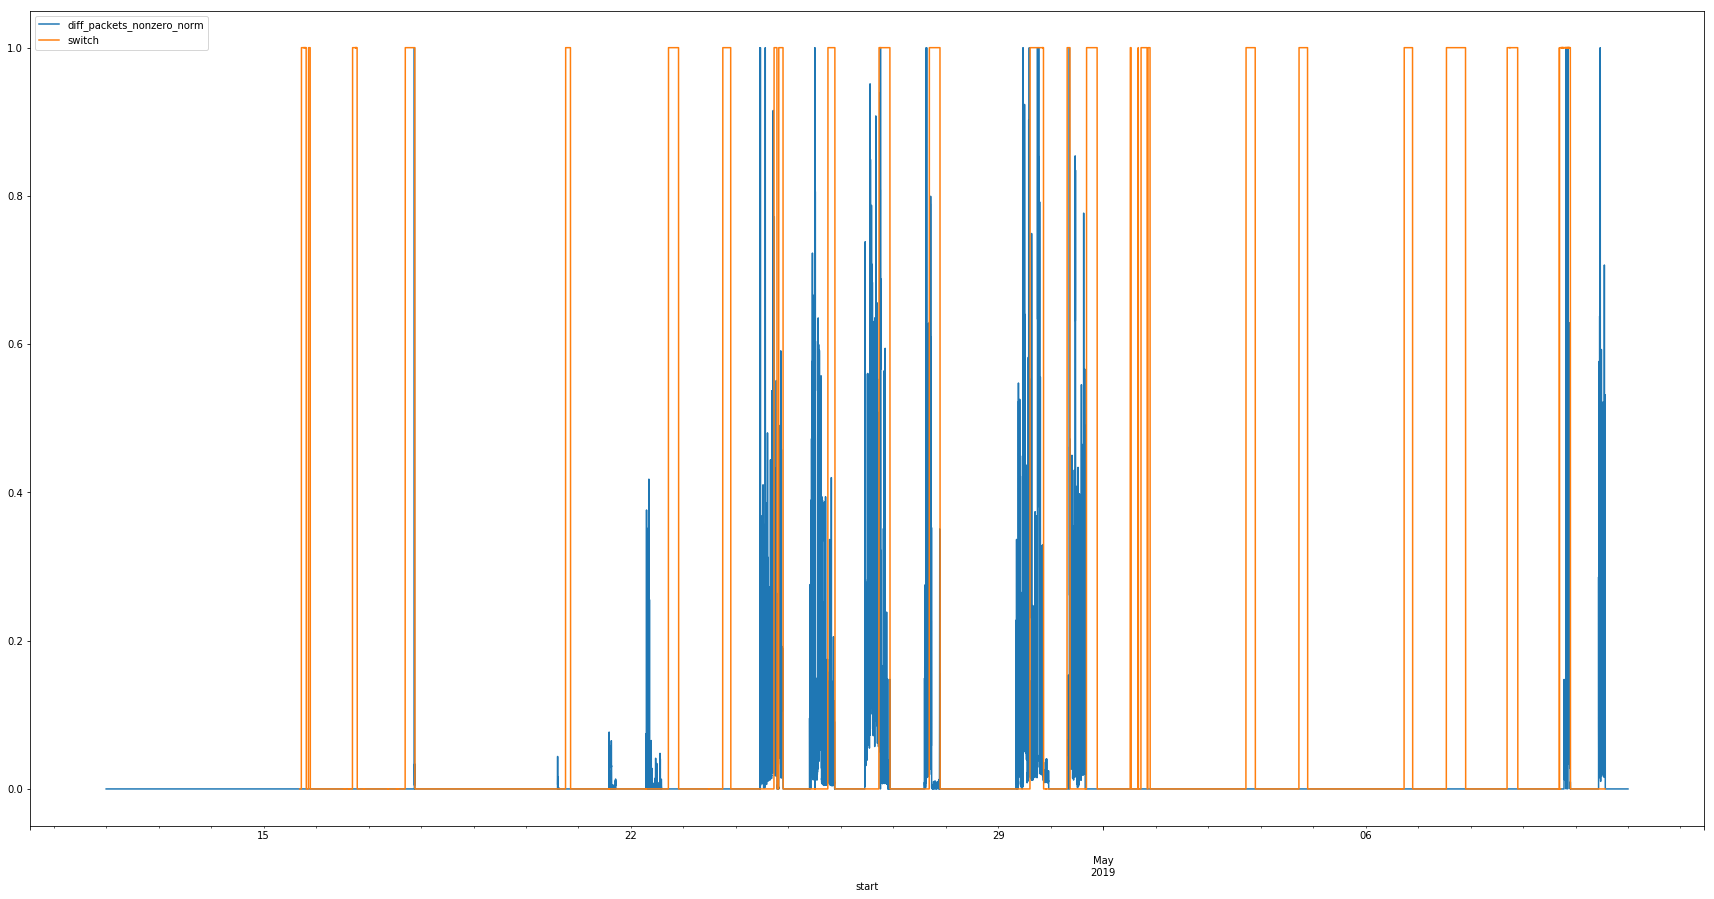

In [55]:
network_switch_norm = data.filter(['diff_packets_nonzero_norm','switch']).join(snapshots)
network_switch_norm.plot.line(y=['diff_packets_nonzero_norm','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/network_switch_norm_plot.png')

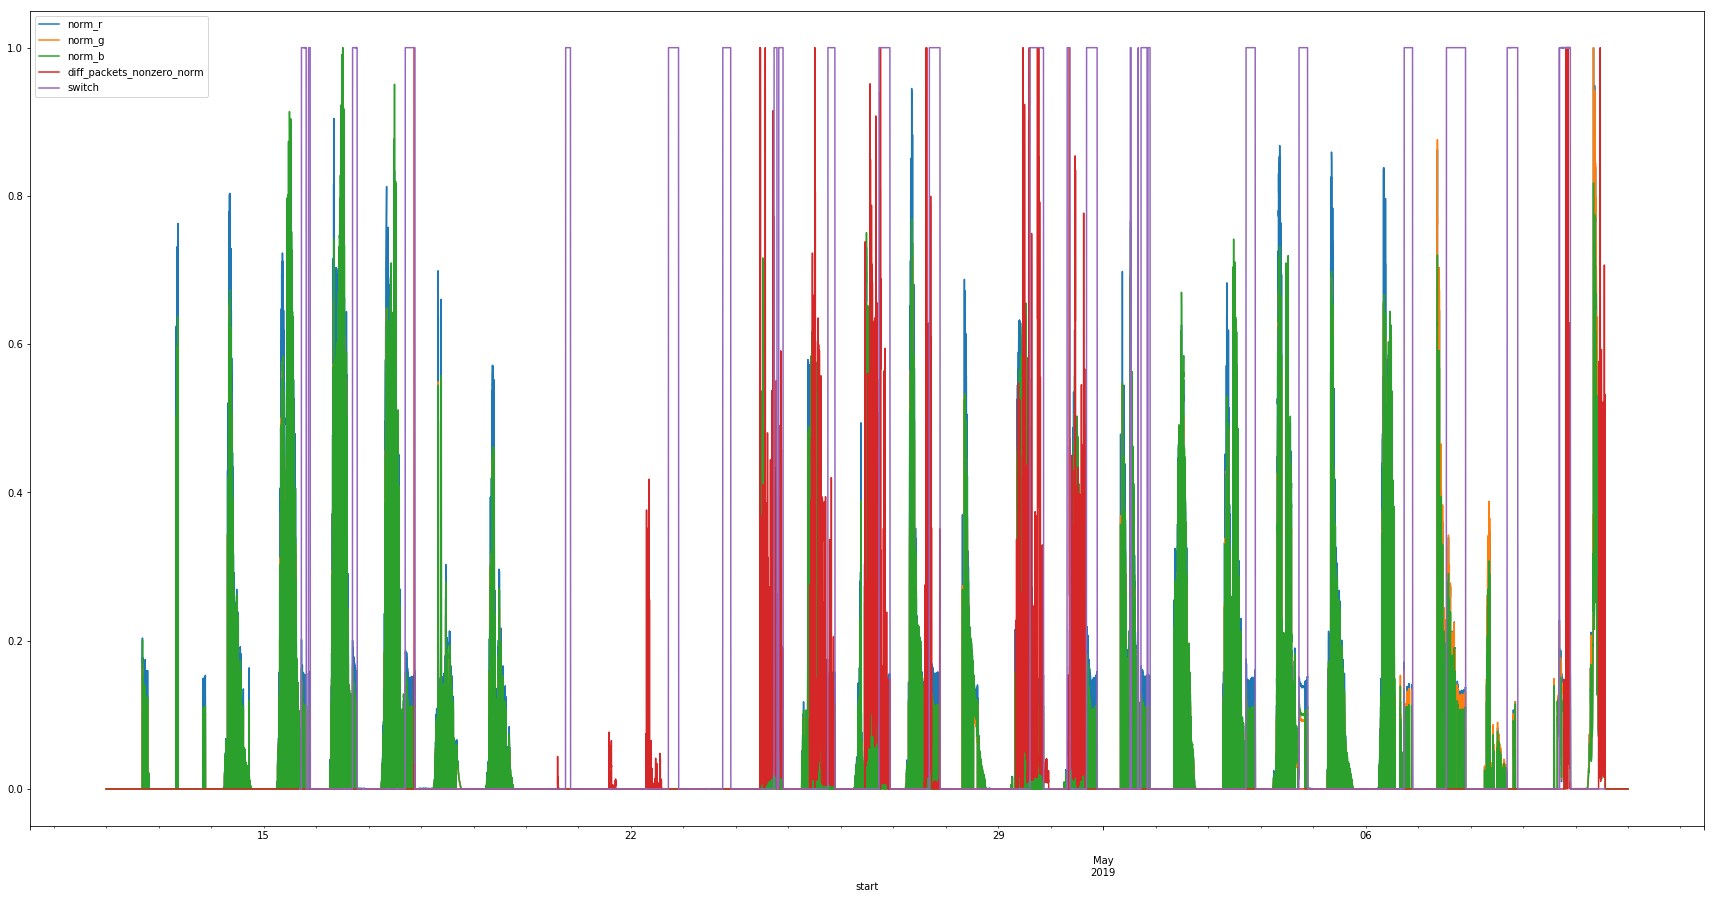

In [56]:
all_data = data.filter(['norm_r','norm_g','norm_b','diff_packets_nonzero_norm','switch']).join(snapshots)
all_data.plot.line(y=['norm_r','norm_g','norm_b','diff_packets_nonzero_norm','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/all_data_plot.png')

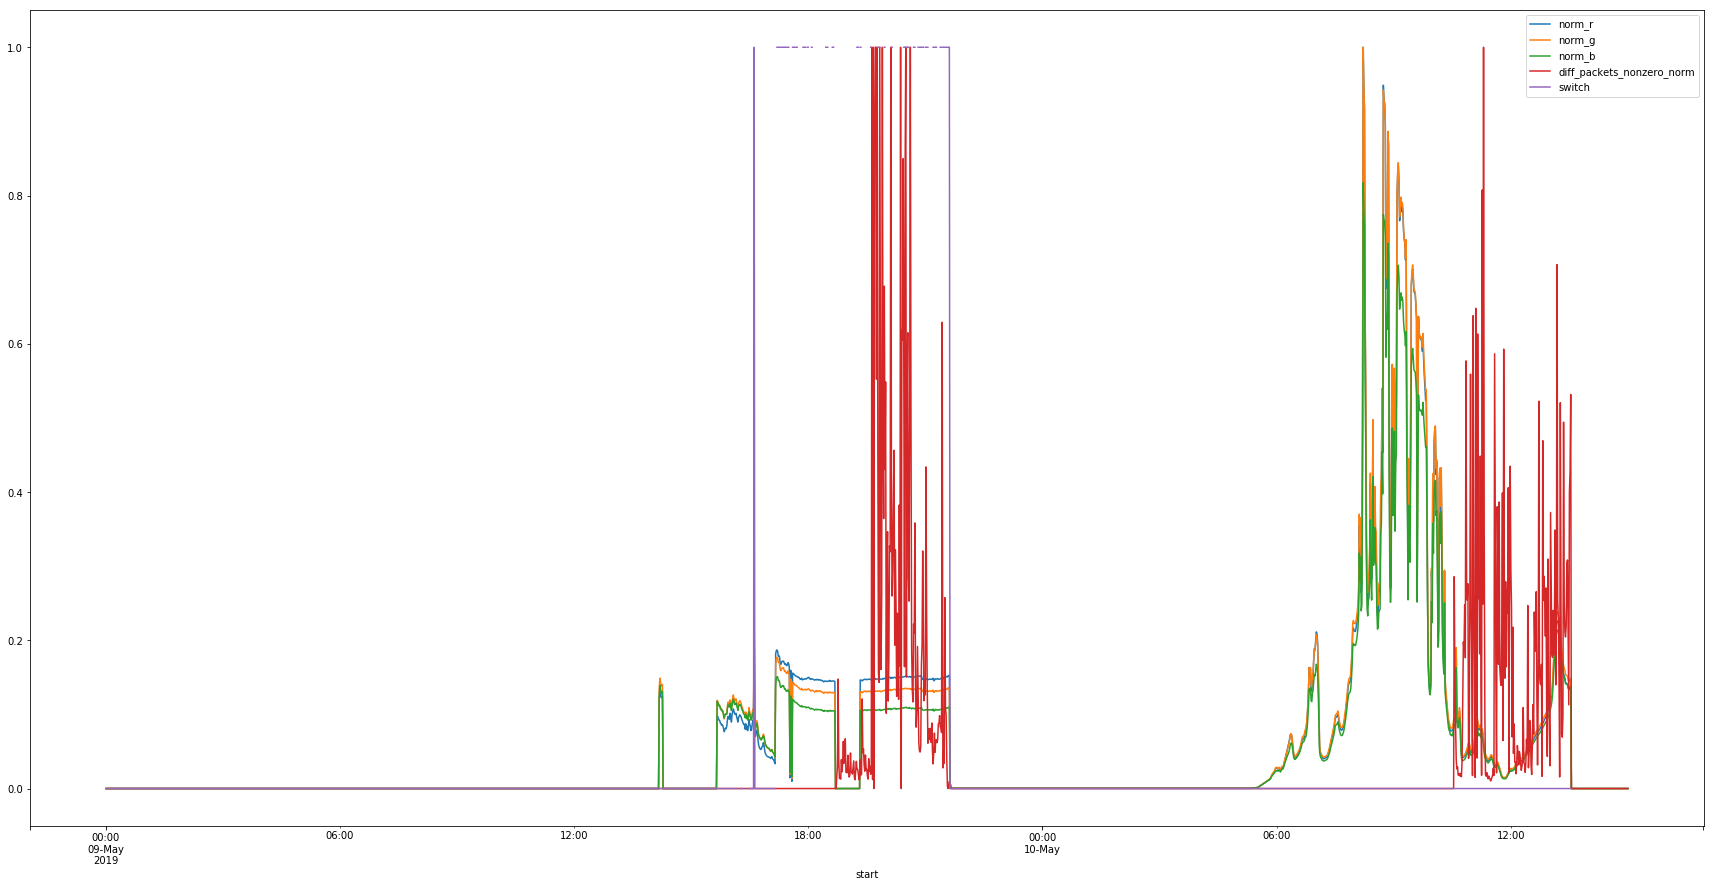

In [58]:
all_data = data.filter(['norm_r','norm_g','norm_b','diff_packets_nonzero_norm','switch']).join(snapshots)
mask = (all_data['start'] > '2019-05-9 00:00:00') & (all_data['start'] <= '2019-05-10 15:00:00')
all_data.loc[mask].plot.line(y=['norm_r','norm_g','norm_b','diff_packets_nonzero_norm','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/apr25_26_all_data_plot.png')